In [1]:
from data_loading import get_loaders
import torch
import torch.nn as nn
import kornia
# import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
M_matrices = torch.tensor([
    # CAM_FRONT_LEFT
    [[-6.92946073e-02, -1.17143003e+00,  1.64122408e+02],
       [-1.33781874e-14, -1.67019853e+00,  2.34084846e+02],
       [-7.00394603e-17, -7.63146706e-03,  1.00000000e+00]], 
    # CAM_FRONT
    [[-6.92636526e-02, -1.17089785e+00,  1.64264194e+02],
       [-1.12965193e-14, -1.66944201e+00,  2.34140507e+02],
       [-5.76795556e-17, -7.62799727e-03,  1.00000000e+00]],
    # CAM_FRONT_RIGHT
    [[-7.02452787e-02, -1.17762492e+00,  1.64369634e+02],
       [-2.27595720e-14, -1.67903365e+00,  2.34318471e+02],
       [-1.16009632e-16, -7.67182090e-03,  1.00000000e+00]],
    # CAM_BACK_LEFT
    [[-6.94775392e-02, -1.17675499e+00,  1.64135286e+02],
       [-1.19904087e-14, -1.67779415e+00,  2.34164782e+02],
       [-5.78963960e-17, -7.66615368e-03,  1.00000000e+00]],
    # CAM_BACK
    [[-6.82085369e-02, -1.16228084e+00,  1.64011808e+02],
       [-1.23234756e-14, -1.65715610e+00,  2.33912863e+02],
       [-6.39679282e-17, -7.57186452e-03,  1.00000000e+00]],
    # CAM_BACK_RIGHT
    [[-6.91003275e-02, -1.16814423e+00,  1.63997347e+02],
       [-1.59872116e-14, -1.66551463e+00,  2.34087152e+02],
       [-8.30498864e-17, -7.61006318e-03,  1.00000000e+00]]
       ])

In [7]:
trainloader, valloader = get_loaders('labeled', batch_size = 2)
sample, target, road_image = iter(trainloader).next()

In [109]:
img_batch = torch.stack(sample)[:,1,:,:,:]

In [110]:
img_warp = kornia.warp_perspective(img_batch, M_matrices[1].unsqueeze(0).repeat(len(img_batch), 1,1), dsize=(204, 306))
img_crop = kornia.center_crop(img_warp, (192,288))

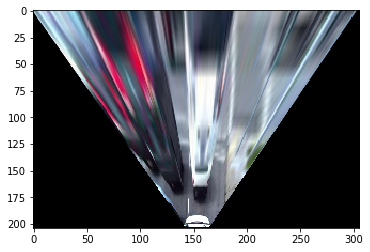

In [111]:
fig, ax = plt.subplots()
ax.imshow(img_warp[1].permute(1,2,0).numpy())

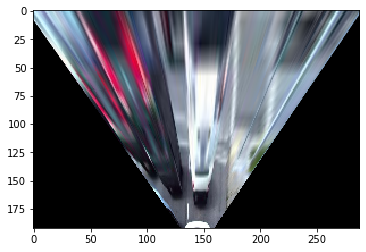

In [112]:
fig, ax = plt.subplots()
ax.imshow(img_crop[1].permute(1,2,0).numpy())

In [2]:
class Loss(nn.Module):

    def __init__(self, feature_size=80, num_bboxes=1, lambda_coord=5.0, lambda_noobj=0.5):
        """ Constructor.
        Args:
            feature_size: (int) size of input feature map.
            num_bboxes: (int) number of bboxes per each cell.
            lambda_coord: (float) weight for bbox location/size losses.
            lambda_noobj: (float) weight for no-objectness loss.
        """
        super(Loss, self).__init__()

        self.S = feature_size
        self.B = num_bboxes
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj


    def compute_iou(self, bbox1, bbox2):
        """ Compute the IoU (Intersection over Union) of two set of bboxes, each bbox format: [x1, y1, x2, y2].
        Args:
            bbox1: (Tensor) bounding bboxes, sized [N, 4].
            bbox2: (Tensor) bounding bboxes, sized [M, 4].
        Returns:
            (Tensor) IoU, sized [N, M].
        """
        N = bbox1.size(0)
        M = bbox2.size(0)

        # Compute left-top coordinate of the intersections
        lt = torch.max(
            bbox1[:, :2].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, :2].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        # Conpute right-bottom coordinate of the intersections
        rb = torch.min(
            bbox1[:, 2:].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, 2:].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        # Compute area of the intersections from the coordinates
        wh = rb - lt   # width and height of the intersection, [N, M, 2]
        wh[wh < 0] = 0 # clip at 0
        inter = wh[:, :, 0] * wh[:, :, 1] # [N, M]

        # Compute area of the bboxes
        area1 = (bbox1[:, 2] - bbox1[:, 0]) * (bbox1[:, 3] - bbox1[:, 1]) # [N, ]
        area2 = (bbox2[:, 2] - bbox2[:, 0]) * (bbox2[:, 3] - bbox2[:, 1]) # [M, ]
        area1 = area1.unsqueeze(1).expand_as(inter) # [N, ] -> [N, 1] -> [N, M]
        area2 = area2.unsqueeze(0).expand_as(inter) # [M, ] -> [1, M] -> [N, M]

        # Compute IoU from the areas
        union = area1 + area2 - inter # [N, M, 2]
        iou = inter / union           # [N, M, 2]

        return iou
    
    def return_target_tensor(self, target):
        tensor_list = []
        B = self.B
        for item in target:
            boxes = item['bounding_box']
            boxes[:,0] = (boxes[:,0]+40)/80
            boxes[:,1] = torch.abs(boxes[:,1]-40)/80

            boxes_max_x = boxes[:, 0].max(dim=1)[0]
            boxes_min_x = boxes[:, 0].min(dim=1)[0]
            boxes_max_y = boxes[:, 1].max(dim=1)[0]
            boxes_min_y = boxes[:, 1].min(dim=1)[0]

            cell_size = 1.0 / 80.0
            targ = torch.zeros(80, 80, B*5)

            boxes = torch.stack((boxes_min_x, boxes_min_y, boxes_max_x, boxes_max_y), 1)

            boxes_wh = boxes[:, 2:] - boxes[:, :2] # width and height for each box, [n, 2]
            boxes_xy = (boxes[:, 2:] + boxes[:, :2]) / 2.0 # center x & y for each box, [n, 2]

            for b in range(boxes.size(0)):
                xy, wh = boxes_xy[b], boxes_wh[b]

                ij = (xy / cell_size).ceil() - 1.0
                i, j = int(ij[0]), int(ij[1]) # y & x index which represents its location on the grid.
                x0y0 = ij * cell_size # x & y of the cell left-top corner.
                xy_normalized = (xy - x0y0) / cell_size

                for k in range(B):
                    s = 5 * k
                    targ[j, i, s  :s+2] = xy_normalized
                    targ[j, i, s+2:s+4] = wh
                    targ[j, i, s+4    ] = 1.0
            tensor_list.append(targ)
        return torch.stack(tensor_list)
    
    def forward(self, pred_tensor, target):
        """ Compute loss for YOLO training.
        Args:
            pred_tensor: (Tensor) predictions, sized [n_batch, S, S, Bx5+C], 5=len([x, y, w, h, conf]).
            target_tensor: (Tensor) targets, sized [n_batch, S, S, Bx5+C].
        Returns:
            (Tensor): loss, sized [1, ].
        """
        # TODO: Romove redundant dimensions for some Tensors.

        target_tensor = self.return_target_tensor(target).cuda()
        
        S, B = self.S, self.B
        N = 5 * B# 5=len([x, y, w, h, conf]

        batch_size = pred_tensor.size(0)
        coord_mask = target_tensor[:, :, :, 4] > 0  # mask for the cells which contain objects. [n_batch, S, S]
        noobj_mask = target_tensor[:, :, :, 4] == 0 # mask for the cells which do not contain objects. [n_batch, S, S]
        coord_mask = coord_mask.unsqueeze(-1).expand_as(target_tensor) # [n_batch, S, S] -> [n_batch, S, S, N]
        noobj_mask = noobj_mask.unsqueeze(-1).expand_as(target_tensor) # [n_batch, S, S] -> [n_batch, S, S, N]

        coord_pred = pred_tensor[coord_mask == 1].view(-1, N)            # pred tensor on the cells which contain objects. [n_coord, N]
                                                                    # n_coord: number of the cells which contain objects.
        bbox_pred = coord_pred[:, :5*B].contiguous().view(-1, 5)    # [n_coord x B, 5=len([x, y, w, h, conf])]                        # [n_coord, C]

        coord_target = target_tensor[coord_mask == 1].view(-1, N)        # target tensor on the cells which contain objects. [n_coord, N]
                                                                    # n_coord: number of the cells which contain objects.
        bbox_target = coord_target[:, :5*B].contiguous().view(-1, 5)# [n_coord x B, 5=len([x, y, w, h, conf])]

        # Compute loss for the cells with no object bbox.
        noobj_pred = pred_tensor[noobj_mask].view(-1, N)        # pred tensor on the cells which do not contain objects. [n_noobj, N]
                                                                # n_noobj: number of the cells which do not contain objects.
        noobj_target = target_tensor[noobj_mask].view(-1, N)    # target tensor on the cells which do not contain objects. [n_noobj, N]
                                                                # n_noobj: number of the cells which do not contain objects.
        noobj_conf_mask = torch.cuda.ByteTensor(noobj_pred.size()).fill_(0) # [n_noobj, N]
        for b in range(B):
            noobj_conf_mask[:, 4 + b*5] = 1 # noobj_conf_mask[:, 4] = 1; noobj_conf_mask[:, 9] = 1
        noobj_pred_conf = noobj_pred[noobj_conf_mask == 1]       # [n_noobj, 2=len([conf1, conf2])]
        noobj_target_conf = noobj_target[noobj_conf_mask == 1]   # [n_noobj, 2=len([conf1, conf2])]
        loss_noobj = F.mse_loss(noobj_pred_conf, noobj_target_conf, reduction='sum')

        # Compute loss for the cells with objects.
        coord_response_mask = torch.cuda.ByteTensor(bbox_target.size()).fill_(0)    # [n_coord x B, 5]
        coord_not_response_mask = torch.cuda.ByteTensor(bbox_target.size()).fill_(1)# [n_coord x B, 5]
        bbox_target_iou = torch.zeros(bbox_target.size()).cuda()                    # [n_coord x B, 5], only the last 1=(conf,) is used

        # Choose the predicted bbox having the highest IoU for each target bbox.
        for i in range(0, bbox_target.size(0), B):
            pred = bbox_pred[i:i+B] # predicted bboxes at i-th cell, [B, 5=len([x, y, w, h, conf])]
            pred_xyxy = Variable(torch.FloatTensor(pred.size())) # [B, 5=len([x1, y1, x2, y2, conf])]
            # Because (center_x,center_y)=pred[:, 2] and (w,h)=pred[:,2:4] are normalized for cell-size and image-size respectively,
            # rescale (center_x,center_y) for the image-size to compute IoU correctly.
            pred_xyxy[:,  :2] = pred[:, 2]/float(S) - 0.5 * pred[:, 2:4]
            pred_xyxy[:, 2:4] = pred[:, 2]/float(S) + 0.5 * pred[:, 2:4]

            target = bbox_target[i] # target bbox at i-th cell. Because target boxes contained by each cell are identical in current implementation, enough to extract the first one.
            target = bbox_target[i].view(-1, 5) # target bbox at i-th cell, [1, 5=len([x, y, w, h, conf])]
            target_xyxy = Variable(torch.FloatTensor(target.size())) # [1, 5=len([x1, y1, x2, y2, conf])]
            # Because (center_x,center_y)=target[:, 2] and (w,h)=target[:,2:4] are normalized for cell-size and image-size respectively,
            # rescale (center_x,center_y) for the image-size to compute IoU correctly.
            target_xyxy[:,  :2] = target[:, 2]/float(S) - 0.5 * target[:, 2:4]
            target_xyxy[:, 2:4] = target[:, 2]/float(S) + 0.5 * target[:, 2:4]

            iou = self.compute_iou(pred_xyxy[:, :4], target_xyxy[:, :4]) # [B, 1]
            max_iou, max_index = iou.max(0)
            max_index = max_index.data.cuda()

            coord_response_mask[i+max_index] = 1
            coord_not_response_mask[i+max_index] = 0

            # "we want the confidence score to equal the intersection over union (IOU) between the predicted box and the ground truth"
            # from the original paper of YOLO.
            bbox_target_iou[i+max_index, torch.LongTensor([4]).cuda()] = (max_iou).data.cuda()
        bbox_target_iou = Variable(bbox_target_iou).cuda()

        # BBox location/size and objectness loss for the response bboxes.
        bbox_pred_response = bbox_pred[coord_response_mask == 1].view(-1, 5)      # [n_response, 5]
        bbox_target_response = bbox_target[coord_response_mask == 1].view(-1, 5)  # [n_response, 5], only the first 4=(x, y, w, h) are used
        target_iou = bbox_target_iou[coord_response_mask == 1].view(-1, 5)        # [n_response, 5], only the last 1=(conf,) is used
        loss_xy = F.mse_loss(bbox_pred_response[:, :2], bbox_target_response[:, :2], reduction='sum')
        loss_wh = F.mse_loss(torch.sqrt(bbox_pred_response[:, 2:4]), torch.sqrt(bbox_target_response[:, 2:4]), reduction='sum')
        loss_obj = F.mse_loss(bbox_pred_response[:, 4], target_iou[:, 4], reduction='sum')

        # Total loss
        loss = self.lambda_coord * (loss_xy + loss_wh) + loss_obj + self.lambda_noobj * loss_noobj
        loss = loss / float(batch_size)

        return loss

In [3]:
class DarkNet(nn.Module):
    def __init__(self):
        super().__init__()        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 5, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(192, 128, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 256, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(512, 256, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 256, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 256, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 256, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 512, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(1024, 512, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(1024, 512, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.conv6 = nn.Sequential(
            nn.Conv2d(1024, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(1024, 1024, 3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
        )
        
    def forward(self, images):  
        
        out = self.conv1(images)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        
        return out

In [4]:
class Yolo(nn.Module):
    def __init__(self):
        super().__init__()

        self.M_matrices = torch.tensor([
        # CAM_FRONT_LEFT
        [[-6.92946073e-02, -1.17143003e+00,  1.64122408e+02],
           [-1.33781874e-14, -1.67019853e+00,  2.34084846e+02],
           [-7.00394603e-17, -7.63146706e-03,  1.00000000e+00]], 
        # CAM_FRONT
        [[-6.92636526e-02, -1.17089785e+00,  1.64264194e+02],
           [-1.12965193e-14, -1.66944201e+00,  2.34140507e+02],
           [-5.76795556e-17, -7.62799727e-03,  1.00000000e+00]],
        # CAM_FRONT_RIGHT
        [[-7.02452787e-02, -1.17762492e+00,  1.64369634e+02],
           [-2.27595720e-14, -1.67903365e+00,  2.34318471e+02],
           [-1.16009632e-16, -7.67182090e-03,  1.00000000e+00]],
        # CAM_BACK_LEFT
        [[-6.94775392e-02, -1.17675499e+00,  1.64135286e+02],
           [-1.19904087e-14, -1.67779415e+00,  2.34164782e+02],
           [-5.78963960e-17, -7.66615368e-03,  1.00000000e+00]],
        # CAM_BACK
        [[-6.82085369e-02, -1.16228084e+00,  1.64011808e+02],
           [-1.23234756e-14, -1.65715610e+00,  2.33912863e+02],
           [-6.39679282e-17, -7.57186452e-03,  1.00000000e+00]],
        # CAM_BACK_RIGHT
        [[-6.91003275e-02, -1.16814423e+00,  1.63997347e+02],
           [-1.59872116e-14, -1.66551463e+00,  2.34087152e+02],
           [-8.30498864e-17, -7.61006318e-03,  1.00000000e+00]]
           ]).to(device)

        # Reshape input to from 219x305 to 204x306 using warp
        # Reshape from 204x306 to 288 x 192 using crop
        
        self.darknet = DarkNet()
        self.pool1 = nn.MaxPool1d(54)
        self.lin1 = nn.Sequential(
            nn.Linear(6 * 1024, 4096),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.5, inplace=False)
        )
        self.lin2 = nn.Sequential(
            nn.Linear(4096, 80*80*5*1),
            nn.Sigmoid()
        )
       
    def forward(self, images):  
        data = []
        
        batch_size = images.shape[0]
        
        for i in range(6):
            img_warp = kornia.warp_perspective(img_batch[:,i,:,:,:], self.M_matrices[i].unsqueeze(0).repeat(len(images), 1,1), dsize=(204, 306))
            img_warp = kornia.center_crop(img_warp, (192,288))
            out = self.darknet(img_warp)
            out = out.view(batch_size,1024,-1)
            out = self.pool1(out).squeeze(-1)
            data.append(out.unsqueeze(1))
        data = torch.cat(data, dim=1)
        
        data = data.view(out.size(0), -1)
        data = self.lin1(data)
        data = self.lin2(data)
        data = data.view(-1, 80, 80, 5 * 1)
        
        return data

In [ ]:
trainloader, valloader = get_loaders('labeled', batch_size = 4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Yolo().to(device)
loss_fxn = Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
for epoch in range(5):
    model.train()
    for i, (sample, target, road_image) in enumerate(trainloader):
        img_batch = torch.stack(sample).to(device)
        
        output = model(img_batch)
        
        loss = loss_fxn(output, target)
        if i % 10 == 0:
            print(loss)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()

In [52]:
trainloader, valloader = get_loaders('labeled', batch_size = 2)
sample, target, road_image = iter(trainloader).next()

img_batch = torch.stack(sample).to(device)
with torch.no_grad():
    output = model(img_batch)

In [56]:
loss = loss_fxn(output, target)

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


In [57]:
loss

tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)

In [318]:
loss = Loss()
loss(output, target)

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


tensor(919.4899, device='cuda:0')

In [58]:
tensor_list = []
B = 1
for item in target:
    boxes = item['bounding_box']
    boxes[:,0] = (boxes[:,0]+40)/80
    boxes[:,1] = torch.abs(boxes[:,1]-40)/80
    
    boxes_max_x = boxes[:, 0].max(dim=1)[0]
    boxes_min_x = boxes[:, 0].min(dim=1)[0]
    boxes_max_y = boxes[:, 1].max(dim=1)[0]
    boxes_min_y = boxes[:, 1].min(dim=1)[0]

    cell_size = 1.0 / 80.0
    targ = torch.zeros(80, 80, B*5)

    boxes = torch.stack((boxes_min_x, boxes_min_y, boxes_max_x, boxes_max_y), 1)

    boxes_wh = boxes[:, 2:] - boxes[:, :2] # width and height for each box, [n, 2]
    boxes_xy = (boxes[:, 2:] + boxes[:, :2]) / 2.0 # center x & y for each box, [n, 2]

    for b in range(boxes.size(0)):
        xy, wh = boxes_xy[b], boxes_wh[b]

        ij = (xy / cell_size).ceil() - 1.0
        i, j = int(ij[0]), int(ij[1]) # y & x index which represents its location on the grid.
        x0y0 = ij * cell_size # x & y of the cell left-top corner.
        xy_normalized = (xy - x0y0) / cell_size
        
        for k in range(B):
            s = 5 * k
            targ[j, i, s  :s+2] = xy_normalized
            targ[j, i, s+2:s+4] = wh
            targ[j, i, s+4    ] = 1.0
    tensor_list.append(targ)
stacked_target = torch.stack(tensor_list)


In [6]:
output = model(img_batch)

NameError: name 'img_batch' is not defined

In [59]:
target_tensor = stacked_target.cuda()

In [60]:
pred_tensor = output

In [23]:
def compute_iou(bbox1, bbox2):
        """ Compute the IoU (Intersection over Union) of two set of bboxes, each bbox format: [x1, y1, x2, y2].
        Args:
            bbox1: (Tensor) bounding bboxes, sized [N, 4].
            bbox2: (Tensor) bounding bboxes, sized [M, 4].
        Returns:
            (Tensor) IoU, sized [N, M].
        """
        N = bbox1.size(0)
        M = bbox2.size(0)

        # Compute left-top coordinate of the intersections
        lt = torch.max(
            bbox1[:, :2].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, :2].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        # Conpute right-bottom coordinate of the intersections
        rb = torch.min(
            bbox1[:, 2:].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, 2:].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        # Compute area of the intersections from the coordinates
        wh = rb - lt   # width and height of the intersection, [N, M, 2]
        wh[wh < 0] = 0 # clip at 0
        inter = wh[:, :, 0] * wh[:, :, 1] # [N, M]

        # Compute area of the bboxes
        area1 = (bbox1[:, 2] - bbox1[:, 0]) * (bbox1[:, 3] - bbox1[:, 1]) # [N, ]
        area2 = (bbox2[:, 2] - bbox2[:, 0]) * (bbox2[:, 3] - bbox2[:, 1]) # [M, ]
        area1 = area1.unsqueeze(1).expand_as(inter) # [N, ] -> [N, 1] -> [N, M]
        area2 = area2.unsqueeze(0).expand_as(inter) # [M, ] -> [1, M] -> [N, M]

        # Compute IoU from the areas
        union = area1 + area2 - inter # [N, M, 2]
        iou = inter / union           # [N, M, 2]

        return iou

In [61]:
S, B = 80, 1
N = 5 * B# 5=len([x, y, w, h, conf]

batch_size = pred_tensor.size(0)
coord_mask = target_tensor[:, :, :, 4] > 0  # mask for the cells which contain objects. [n_batch, S, S]
noobj_mask = target_tensor[:, :, :, 4] == 0 # mask for the cells which do not contain objects. [n_batch, S, S]
coord_mask = coord_mask.unsqueeze(-1).expand_as(target_tensor) # [n_batch, S, S] -> [n_batch, S, S, N]
noobj_mask = noobj_mask.unsqueeze(-1).expand_as(target_tensor) # [n_batch, S, S] -> [n_batch, S, S, N]


coord_pred = pred_tensor[coord_mask].view(-1, N)            # pred tensor on the cells which contain objects. [n_coord, N]
                                                            # n_coord: number of the cells which contain objects.
bbox_pred = coord_pred[:, :5*B].contiguous().view(-1, 5)   # [n_coord x B, 5=len([x, y, w, h, conf])]                        # [n_coord, C]

coord_target = target_tensor[coord_mask].view(-1, N)        # target tensor on the cells which contain objects. [n_coord, N]
                                                            # n_coord: number of the cells which contain objects.
bbox_target = coord_target[:, :5*B].contiguous().view(-1, 5)# [n_coord x B, 5=len([x, y, w, h, conf])]

# Compute loss for the cells with no object bbox.
noobj_pred = pred_tensor[noobj_mask].view(-1, N)        # pred tensor on the cells which do not contain objects. [n_noobj, N]
                                                        # n_noobj: number of the cells which do not contain objects.
noobj_target = target_tensor[noobj_mask].view(-1, N)    # target tensor on the cells which do not contain objects. [n_noobj, N]
                                                        # n_noobj: number of the cells which do not contain objects.
noobj_conf_mask = torch.cuda.ByteTensor(noobj_pred.size()).fill_(0) # [n_noobj, N]
for b in range(B):
    noobj_conf_mask[:, 4 + b*5] = 1 # noobj_conf_mask[:, 4] = 1; noobj_conf_mask[:, 9] = 1
noobj_pred_conf = noobj_pred[noobj_conf_mask == 1]       # [n_noobj, 2=len([conf1, conf2])]
noobj_target_conf = noobj_target[noobj_conf_mask == 1]   # [n_noobj, 2=len([conf1, conf2])]
loss_noobj = F.mse_loss(noobj_pred_conf, noobj_target_conf, reduction='sum')

# Compute loss for the cells with objects.
coord_response_mask = torch.cuda.ByteTensor(bbox_target.size()).fill_(0)    # [n_coord x B, 5]
coord_not_response_mask = torch.cuda.ByteTensor(bbox_target.size()).fill_(1)# [n_coord x B, 5]
bbox_target_iou = torch.zeros(bbox_target.size()).cuda()                    # [n_coord x B, 5], only the last 1=(conf,) is used

# Choose the predicted bbox having the highest IoU for each target bbox.
for i in range(0, bbox_target.size(0), B):
    pred = bbox_pred[i:i+B] # predicted bboxes at i-th cell, [B, 5=len([x, y, w, h, conf])]
    pred_xyxy = Variable(torch.FloatTensor(pred.size())) # [B, 5=len([x1, y1, x2, y2, conf])]
    # Because (center_x,center_y)=pred[:, 2] and (w,h)=pred[:,2:4] are normalized for cell-size and image-size respectively,
    # rescale (center_x,center_y) for the image-size to compute IoU correctly.
    pred_xyxy[:,  :2] = pred[:, 2]/float(S) - 0.5 * pred[:, 2:4]
    pred_xyxy[:, 2:4] = pred[:, 2]/float(S) + 0.5 * pred[:, 2:4]

    target = bbox_target[i] # target bbox at i-th cell. Because target boxes contained by each cell are identical in current implementation, enough to extract the first one.
    target = bbox_target[i].view(-1, 5) # target bbox at i-th cell, [1, 5=len([x, y, w, h, conf])]
    target_xyxy = Variable(torch.FloatTensor(target.size())) # [1, 5=len([x1, y1, x2, y2, conf])]
    # Because (center_x,center_y)=target[:, 2] and (w,h)=target[:,2:4] are normalized for cell-size and image-size respectively,
    # rescale (center_x,center_y) for the image-size to compute IoU correctly.
    target_xyxy[:,  :2] = target[:, 2]/float(S) - 0.5 * target[:, 2:4]
    target_xyxy[:, 2:4] = target[:, 2]/float(S) + 0.5 * target[:, 2:4]

    iou = compute_iou(pred_xyxy[:, :4], target_xyxy[:, :4]) # [B, 1]
    max_iou, max_index = iou.max(0)
    max_index = max_index.data.cuda()

    coord_response_mask[i+max_index] = 1
    coord_not_response_mask[i+max_index] = 0

    # "we want the confidence score to equal the intersection over union (IOU) between the predicted box and the ground truth"
    # from the original paper of YOLO.
    bbox_target_iou[i+max_index, torch.LongTensor([4]).cuda()] = (max_iou).data.cuda()
bbox_target_iou = Variable(bbox_target_iou).cuda()

# BBox location/size and objectness loss for the response bboxes.
bbox_pred_response = bbox_pred[coord_response_mask == 1].view(-1, 5)      # [n_response, 5]
bbox_target_response = bbox_target[coord_response_mask == 1].view(-1, 5)  # [n_response, 5], only the first 4=(x, y, w, h) are used
target_iou = bbox_target_iou[coord_response_mask == 1].view(-1, 5)        # [n_response, 5], only the last 1=(conf,) is used
loss_xy = F.mse_loss(bbox_pred_response[:, :2], bbox_target_response[:, :2], reduction='sum')
loss_wh = F.mse_loss(torch.sqrt(bbox_pred_response[:, 2:4]), torch.sqrt(bbox_target_response[:, 2:4]), reduction='sum')
loss_obj = F.mse_loss(bbox_pred_response[:, 4].cuda(), target_iou[:, 4], reduction='sum')

loss = 5.0 * (loss_xy + loss_wh) + loss_obj + 0.5 * loss_noobj
loss = loss / float(batch_size)

In [71]:
coord_pred = pred_tensor[coord_mask].view(-1, N)  

In [72]:
coord_pred

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]], device='cuda:0', grad_fn=<ViewBackward>)

In [288]:
loss_wh

tensor(2.6557)

In [281]:
bbox_pred

tensor([[ 1.1171, -0.0403, -0.1150, -0.0147,  0.0000],
        [ 2.5984,  0.0538, -0.1553,  0.0000,  0.0000]])

In [247]:
coord_response_mask

tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]], device='cuda:0', dtype=torch.uint8)

In [243]:
pred

tensor([[ 2.5984,  0.0538, -0.1553,  0.0000,  0.0000]])

In [244]:
pred_xyxy

tensor([[ 0.0757, -0.0019, -0.0796, -0.0019,  0.0000]])

In [239]:
noobj_pred_conf.shape

torch.Size([12798])

In [234]:
noobj_target_conf.shape

torch.Size([12798])

In [223]:
pred_tensor = output.cpu()
target_tensor = stacked_target.cpu()
B = 1
N = 5*B

In [224]:
coord_mask = target_tensor[:, :, :, 4] > 0  # mask for the cells which contain objects. [n_batch, S, S]
noobj_mask = target_tensor[:, :, :, 4] == 0 # mask for the cells which do not contain objects. [n_batch, S, S]
coord_mask = coord_mask.unsqueeze(-1).expand_as(target_tensor) # [n_batch, S, S] -> [n_batch, S, S, N]
noobj_mask = noobj_mask.unsqueeze(-1).expand_as(target_tensor) 

In [225]:
coord_pred = pred_tensor[coord_mask].view(-1, N)  

In [226]:
coord_pred.shape

torch.Size([2, 5])

In [227]:
bbox_pred = coord_pred[:, :5*B].contiguous().view(-1, 5) 

In [228]:
bbox_pred.shape

torch.Size([2, 5])

In [171]:
coord_target = target_tensor[coord_mask].view(-1, N)        # target tensor on the cells which contain objects. [n_coord, N]
                                                            # n_coord: number of the cells which contain objects.
bbox_target = coord_target[:, :5*B].contiguous().view(-1, 5)

In [172]:
coord_target = target_tensor[coord_mask].view(-1, N)        # target tensor on the cells which contain objects. [n_coord, N]
                                                            # n_coord: number of the cells which contain objects.
bbox_target = coord_target[:, :5*B].contiguous().view(-1, 5)

In [240]:
def compute_iou(bbox1, bbox2):
    """ Compute the IoU (Intersection over Union) of two set of bboxes, each bbox format: [x1, y1, x2, y2].
    Args:
        bbox1: (Tensor) bounding bboxes, sized [N, 4].
        bbox2: (Tensor) bounding bboxes, sized [M, 4].
    Returns:
        (Tensor) IoU, sized [N, M].
    """
    N = bbox1.size(0)
    M = bbox2.size(0)

    # Compute left-top coordinate of the intersections
    lt = torch.max(
        bbox1[:, :2].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
        bbox2[:, :2].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
    )
    # Conpute right-bottom coordinate of the intersections
    rb = torch.min(
        bbox1[:, 2:].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
        bbox2[:, 2:].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
    )
    # Compute area of the intersections from the coordinates
    wh = rb - lt   # width and height of the intersection, [N, M, 2]
    wh[wh < 0] = 0 # clip at 0
    inter = wh[:, :, 0] * wh[:, :, 1] # [N, M]

    # Compute area of the bboxes
    area1 = (bbox1[:, 2] - bbox1[:, 0]) * (bbox1[:, 3] - bbox1[:, 1]) # [N, ]
    area2 = (bbox2[:, 2] - bbox2[:, 0]) * (bbox2[:, 3] - bbox2[:, 1]) # [M, ]
    area1 = area1.unsqueeze(1).expand_as(inter) # [N, ] -> [N, 1] -> [N, M]
    area2 = area2.unsqueeze(0).expand_as(inter) # [M, ] -> [1, M] -> [N, M]

    # Compute IoU from the areas
    union = area1 + area2 - inter # [N, M, 2]
    iou = inter / union           # [N, M, 2]

    return iou

In [5]:
class Loss(nn.Module):

    def __init__(self, feature_size=80, num_bboxes=1, lambda_coord=5.0, lambda_noobj=0.5):
        """ Constructor.
        Args:
            feature_size: (int) size of input feature map.
            num_bboxes: (int) number of bboxes per each cell.
            lambda_coord: (float) weight for bbox location/size losses.
            lambda_noobj: (float) weight for no-objectness loss.
        """
        super(Loss, self).__init__()

        self.S = feature_size
        self.B = num_bboxes
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj


    def compute_iou(self, bbox1, bbox2):
        """ Compute the IoU (Intersection over Union) of two set of bboxes, each bbox format: [x1, y1, x2, y2].
        Args:
            bbox1: (Tensor) bounding bboxes, sized [N, 4].
            bbox2: (Tensor) bounding bboxes, sized [M, 4].
        Returns:
            (Tensor) IoU, sized [N, M].
        """
        N = bbox1.size(0)
        M = bbox2.size(0)

        # Compute left-top coordinate of the intersections
        lt = torch.max(
            bbox1[:, :2].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, :2].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        # Conpute right-bottom coordinate of the intersections
        rb = torch.min(
            bbox1[:, 2:].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, 2:].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        # Compute area of the intersections from the coordinates
        wh = rb - lt   # width and height of the intersection, [N, M, 2]
        wh[wh < 0] = 0 # clip at 0
        inter = wh[:, :, 0] * wh[:, :, 1] # [N, M]

        # Compute area of the bboxes
        area1 = (bbox1[:, 2] - bbox1[:, 0]) * (bbox1[:, 3] - bbox1[:, 1]) # [N, ]
        area2 = (bbox2[:, 2] - bbox2[:, 0]) * (bbox2[:, 3] - bbox2[:, 1]) # [M, ]
        area1 = area1.unsqueeze(1).expand_as(inter) # [N, ] -> [N, 1] -> [N, M]
        area2 = area2.unsqueeze(0).expand_as(inter) # [M, ] -> [1, M] -> [N, M]

        # Compute IoU from the areas
        union = area1 + area2 - inter # [N, M, 2]
        iou = inter / union           # [N, M, 2]

        return iou
    
    def return_target_tensor(self, target):
        tensor_list = []
        B = self.B
        for item in target:
            boxes = item['bounding_box']
            boxes[:,0] = (boxes[:,0]+40)/80
            boxes[:,1] = torch.abs(boxes[:,1]-40)/80

            boxes_max_x = boxes[:, 0].max(dim=1)[0]
            boxes_min_x = boxes[:, 0].min(dim=1)[0]
            boxes_max_y = boxes[:, 1].max(dim=1)[0]
            boxes_min_y = boxes[:, 1].min(dim=1)[0]

            cell_size = 1.0 / 80.0
            targ = torch.zeros(80, 80, B*5)

            boxes = torch.stack((boxes_min_x, boxes_min_y, boxes_max_x, boxes_max_y), 1)

            boxes_wh = boxes[:, 2:] - boxes[:, :2] # width and height for each box, [n, 2]
            boxes_xy = (boxes[:, 2:] + boxes[:, :2]) / 2.0 # center x & y for each box, [n, 2]

            for b in range(boxes.size(0)):
                xy, wh = boxes_xy[b], boxes_wh[b]

                ij = (xy / cell_size).ceil() - 1.0
                i, j = int(ij[0]), int(ij[1]) # y & x index which represents its location on the grid.
                x0y0 = ij * cell_size # x & y of the cell left-top corner.
                xy_normalized = (xy - x0y0) / cell_size

                for k in range(B):
                    s = 5 * k
                    targ[j, i, s  :s+2] = xy_normalized
                    targ[j, i, s+2:s+4] = wh
                    targ[j, i, s+4    ] = 1.0
            tensor_list.append(targ)
        return torch.stack(tensor_list)
    
    def forward(self, pred_tensor, target):
        """ Compute loss for YOLO training.
        Args:
            pred_tensor: (Tensor) predictions, sized [n_batch, S, S, Bx5+C], 5=len([x, y, w, h, conf]).
            target_tensor: (Tensor) targets, sized [n_batch, S, S, Bx5+C].
        Returns:
            (Tensor): loss, sized [1, ].
        """
        # TODO: Romove redundant dimensions for some Tensors.

        target_tensor = self.return_target_tensor(target).cuda()
        
        S, B = self.S, self.B
        N = 5 * B# 5=len([x, y, w, h, conf]

        batch_size = pred_tensor.size(0)
        coord_mask = target_tensor[:, :, :, 4] > 0  # mask for the cells which contain objects. [n_batch, S, S]
        noobj_mask = target_tensor[:, :, :, 4] == 0 # mask for the cells which do not contain objects. [n_batch, S, S]
        coord_mask = coord_mask.unsqueeze(-1).expand_as(target_tensor) # [n_batch, S, S] -> [n_batch, S, S, N]
        noobj_mask = noobj_mask.unsqueeze(-1).expand_as(target_tensor) # [n_batch, S, S] -> [n_batch, S, S, N]

        coord_pred = pred_tensor[coord_mask == 1].view(-1, N)            # pred tensor on the cells which contain objects. [n_coord, N]
                                                                    # n_coord: number of the cells which contain objects.
        bbox_pred = coord_pred[:, :5*B].contiguous().view(-1, 5)    # [n_coord x B, 5=len([x, y, w, h, conf])]                        # [n_coord, C]

        coord_target = target_tensor[coord_mask == 1].view(-1, N)        # target tensor on the cells which contain objects. [n_coord, N]
                                                                    # n_coord: number of the cells which contain objects.
        bbox_target = coord_target[:, :5*B].contiguous().view(-1, 5)# [n_coord x B, 5=len([x, y, w, h, conf])]

        # Compute loss for the cells with no object bbox.
        noobj_pred = pred_tensor[noobj_mask].view(-1, N)        # pred tensor on the cells which do not contain objects. [n_noobj, N]
                                                                # n_noobj: number of the cells which do not contain objects.
        noobj_target = target_tensor[noobj_mask].view(-1, N)    # target tensor on the cells which do not contain objects. [n_noobj, N]
                                                                # n_noobj: number of the cells which do not contain objects.
        noobj_conf_mask = torch.cuda.ByteTensor(noobj_pred.size()).fill_(0) # [n_noobj, N]
        for b in range(B):
            noobj_conf_mask[:, 4 + b*5] = 1 # noobj_conf_mask[:, 4] = 1; noobj_conf_mask[:, 9] = 1
        noobj_pred_conf = noobj_pred[noobj_conf_mask == 1]       # [n_noobj, 2=len([conf1, conf2])]
        noobj_target_conf = noobj_target[noobj_conf_mask == 1]   # [n_noobj, 2=len([conf1, conf2])]
        loss_noobj = F.mse_loss(noobj_pred_conf, noobj_target_conf, reduction='sum')

        # Compute loss for the cells with objects.
        coord_response_mask = torch.cuda.ByteTensor(bbox_target.size()).fill_(0)    # [n_coord x B, 5]
        coord_not_response_mask = torch.cuda.ByteTensor(bbox_target.size()).fill_(1)# [n_coord x B, 5]
        bbox_target_iou = torch.zeros(bbox_target.size()).cuda()                    # [n_coord x B, 5], only the last 1=(conf,) is used

        # Choose the predicted bbox having the highest IoU for each target bbox.
        for i in range(0, bbox_target.size(0), B):
            pred = bbox_pred[i:i+B] # predicted bboxes at i-th cell, [B, 5=len([x, y, w, h, conf])]
            pred_xyxy = Variable(torch.FloatTensor(pred.size())) # [B, 5=len([x1, y1, x2, y2, conf])]
            # Because (center_x,center_y)=pred[:, 2] and (w,h)=pred[:,2:4] are normalized for cell-size and image-size respectively,
            # rescale (center_x,center_y) for the image-size to compute IoU correctly.
            pred_xyxy[:,  :2] = pred[:, 2]/float(S) - 0.5 * pred[:, 2:4]
            pred_xyxy[:, 2:4] = pred[:, 2]/float(S) + 0.5 * pred[:, 2:4]

            target = bbox_target[i] # target bbox at i-th cell. Because target boxes contained by each cell are identical in current implementation, enough to extract the first one.
            target = bbox_target[i].view(-1, 5) # target bbox at i-th cell, [1, 5=len([x, y, w, h, conf])]
            target_xyxy = Variable(torch.FloatTensor(target.size())) # [1, 5=len([x1, y1, x2, y2, conf])]
            # Because (center_x,center_y)=target[:, 2] and (w,h)=target[:,2:4] are normalized for cell-size and image-size respectively,
            # rescale (center_x,center_y) for the image-size to compute IoU correctly.
            target_xyxy[:,  :2] = target[:, 2]/float(S) - 0.5 * target[:, 2:4]
            target_xyxy[:, 2:4] = target[:, 2]/float(S) + 0.5 * target[:, 2:4]

            iou = self.compute_iou(pred_xyxy[:, :4], target_xyxy[:, :4]) # [B, 1]
            max_iou, max_index = iou.max(0)
            max_index = max_index.data.cuda()

            coord_response_mask[i+max_index] = 1
            coord_not_response_mask[i+max_index] = 0

            # "we want the confidence score to equal the intersection over union (IOU) between the predicted box and the ground truth"
            # from the original paper of YOLO.
            bbox_target_iou[i+max_index, torch.LongTensor([4]).cuda()] = (max_iou).data.cuda()
        bbox_target_iou = Variable(bbox_target_iou).cuda()

        # BBox location/size and objectness loss for the response bboxes.
        bbox_pred_response = bbox_pred[coord_response_mask == 1].view(-1, 5)      # [n_response, 5]
        bbox_target_response = bbox_target[coord_response_mask == 1].view(-1, 5)  # [n_response, 5], only the first 4=(x, y, w, h) are used
        target_iou = bbox_target_iou[coord_response_mask == 1].view(-1, 5)        # [n_response, 5], only the last 1=(conf,) is used
        loss_xy = F.mse_loss(bbox_pred_response[:, :2], bbox_target_response[:, :2], reduction='sum')
        loss_wh = F.mse_loss(torch.sqrt(bbox_pred_response[:, 2:4]), torch.sqrt(bbox_target_response[:, 2:4]), reduction='sum')
        loss_obj = F.mse_loss(bbox_pred_response[:, 4], target_iou[:, 4], reduction='sum')

        # Total loss
        loss = self.lambda_coord * (loss_xy + loss_wh) + loss_obj + self.lambda_noobj * loss_noobj
        loss = loss / float(batch_size)

        return loss

In [139]:
line = '000358.jpg 89 100 387 284 6 90 99 387 284 6'
splitted = line.strip().split()
num_boxes = (len(splitted) - 1) // 5
box, label = [], []
for i in range(num_boxes):
    x1 = float(splitted[5*i + 1])
    y1 = float(splitted[5*i + 2])
    x2 = float(splitted[5*i + 3])
    y2 = float(splitted[5*i + 4])
    c  =   int(splitted[5*i + 5])
    box.append([x1, y1, x2, y2])
    label.append(c)

In [140]:
boxes

tensor([[0.1780, 0.3003, 0.7740, 0.8529],
        [0.0460, 0.0991, 0.2200, 0.8619]])

In [190]:
# boxes = []
# boxes.append(torch.Tensor(box))
boxes = torch.Tensor(box)

In [191]:
boxes

tensor([[ 89., 100., 387., 284.],
        [ 90.,  99., 387., 284.]])

In [192]:
h, w, = 333, 500

In [193]:
boxes /= torch.Tensor([[w, h, w, h]]).expand_as(boxes)

In [194]:
boxes

tensor([[0.1780, 0.3003, 0.7740, 0.8529],
        [0.1800, 0.2973, 0.7740, 0.8529]])

In [195]:
S, B, C = 7,2,0

In [196]:
N = 5 * B + C

In [197]:
target = torch.zeros(S, S, N)

In [198]:
cell_size = 1.0 / float(S)

In [199]:
cell_size

0.14285714285714285

In [200]:
boxes_wh = boxes[:, 2:] - boxes[:, :2] # width and height for each box, [n, 2]
boxes_xy = (boxes[:, 2:] + boxes[:, :2]) / 2.0 # center x & y for each box, [n, 2]

In [201]:
boxes_wh

tensor([[0.5960, 0.5526],
        [0.5940, 0.5556]])

In [202]:
boxes

tensor([[0.1780, 0.3003, 0.7740, 0.8529],
        [0.1800, 0.2973, 0.7740, 0.8529]])

In [203]:
for b in range(boxes.size(0)):
    xy, wh = boxes_xy[b], boxes_wh[b]

    ij = (xy / cell_size).ceil() - 1.0
    i, j = int(ij[0]), int(ij[1]) # y & x index which represents its location on the grid.
    x0y0 = ij * cell_size # x & y of the cell left-top corner.
    xy_normalized = (xy - x0y0) / cell_size
    for k in range(B):
        s = 5 * k
        target[j, i, s  :s+2] = xy_normalized
        target[j, i, s+2:s+4] = wh
        target[j, i, s+4    ] = 1.0

In [204]:
boxes_xy

tensor([[0.4760, 0.5766],
        [0.4770, 0.5751]])

In [155]:
boxes_wh

tensor([[0.5960, 0.5526],
        [0.5940, 0.5556]])

In [43]:
boxes_xy

tensor([[0.4760, 0.5766],
        [0.1330, 0.4805]])

In [47]:
boxes_xy[0]

tensor([0.4760, 0.5766])

In [7]:
import train
import torch

In [4]:
import train
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load('model_best.pth.tar', map_location=device)
model = train.Yolo(80,1, device).to(device)
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [145]:
from data_loading import get_loaders
trainloader, valloader = get_loaders('labeled', batch_size = 2)

In [126]:
sample, target, road_image = iter(valloader).next()
img_batch = torch.stack(sample).to(device)
with torch.no_grad():
    out = model(img_batch)

In [122]:
out[1,:,:,4].shape

torch.Size([80, 80])

In [176]:
def decode(pred_tensor):
    """ Decode tensor into box coordinates, class labels, and probs_detected.
    Args:
        pred_tensor: (tensor) tensor to decode sized [S, S, 5 x B + C], 5=(x, y, w, h, conf)
    Returns:
        boxes: (tensor) [[x1, y1, x2, y2]_obj1, ...]. Normalized from 0.0 to 1.0 w.r.t. image width/height, sized [n_boxes, 4].
        labels: (tensor) class labels for each detected boxe, sized [n_boxes,].
        confidences: (tensor) objectness confidences for each detected box, sized [n_boxes,].
        class_scores: (tensor) scores for most likely class for each detected box, sized [n_boxes,].
    """
    conf_thresh = 0.015
    
    S, B, C = 80, 1, 0
    boxes, labels, confidences, class_scores = [], [], [], []

    cell_size = 1.0 / float(S)

    conf = pred_tensor[:, :, 4].unsqueeze(2) # [S, S, 1]
    for b in range(1, B):
        conf = torch.cat((conf, pred_tensor[:, :, 5*b + 4].unsqueeze(2)), 2)
    conf_mask = conf > conf_thresh # [S, S, B]

    for i in range(S): # for x-dimension.
        for j in range(S): # for y-dimension.

            for b in range(B):
                conf = pred_tensor[j, i, 5*b + 4]
                prob = conf * 1
                if float(prob) < conf_thresh:
                    continue

                # Compute box corner (x1, y1, x2, y2) from tensor.
                box = pred_tensor[j, i, 5*b : 5*b + 4]
                x0y0_normalized = torch.FloatTensor([i, j]) * cell_size # cell left-top corner. Normalized from 0.0 to 1.0 w.r.t. image width/height.
                xy_normalized = box[:2] * cell_size + x0y0_normalized   # box center. Normalized from 0.0 to 1.0 w.r.t. image width/height.
                wh_normalized = box[2:] # Box width and height. Normalized from 0.0 to 1.0 w.r.t. image width/height.
                box_xyxy = torch.FloatTensor(2,4) # [4,]
                box_xyxy[:,0] = xy_normalized - 0.5 * wh_normalized # left-top corner (x1, y1).
                box_xyxy[:,3] = xy_normalized + 0.5 * wh_normalized # right-bottom corner (x2, y2).
                box_xyxy[0,1] = box_xyxy[0,3]
                box_xyxy[1,1] = box_xyxy[1,0]
                box_xyxy[0,2] = box_xyxy[0,1]
                box_xyxy[1,2] = box_xyxy[1,3]
                
                # Append result to the lists.
                boxes.append(box_xyxy)

    if len(boxes) > 0:
        boxes = torch.stack(boxes, 0)
    else:
        boxes = torch.zeros(1,2,4)

    return boxes

In [186]:
total_ats_bounding_boxes

tensor(1.)

In [175]:
target[j]['bounding_box']

tensor([[[-0.3275,  0.3595, -0.2880,  0.3990],
         [11.9196, 11.9657, 11.3073, 11.3534]]], dtype=torch.float64)

In [149]:
out.shape

torch.Size([2, 80, 80, 5])

In [129]:
target[1]

{'bounding_box': tensor([[[ 4.4262,  5.1142,  4.4076,  5.0955],
          [11.9377, 11.9188, 11.3242, 11.3054]]], dtype=torch.float64),
 'category': tensor([3])}

In [112]:
(0.5104*80)-40

0.8319999999999936

In [115]:
40 - 0.5006*80

-0.04800000000000182

In [144]:
compute_ats_bounding_boxes(decode(out[1].cpu()), target[1]['bounding_box'])

tensor(0.)

In [140]:
from shapely.geometry import Polygon

def compute_ats_bounding_boxes(boxes1, boxes2):
    num_boxes1 = boxes1.size(0)
    num_boxes2 = boxes2.size(0)

    boxes1_max_x = boxes1[:, 0].max(dim=1)[0]
    boxes1_min_x = boxes1[:, 0].min(dim=1)[0]
    boxes1_max_y = boxes1[:, 1].max(dim=1)[0]
    boxes1_min_y = boxes1[:, 1].min(dim=1)[0]

    boxes2_max_x = boxes2[:, 0].max(dim=1)[0]
    boxes2_min_x = boxes2[:, 0].min(dim=1)[0]
    boxes2_max_y = boxes2[:, 1].max(dim=1)[0]
    boxes2_min_y = boxes2[:, 1].min(dim=1)[0]

    condition1_matrix = (boxes1_max_x.unsqueeze(1) > boxes2_min_x.unsqueeze(0))
    condition2_matrix = (boxes1_min_x.unsqueeze(1) < boxes2_max_x.unsqueeze(0))
    condition3_matrix = (boxes1_max_y.unsqueeze(1) > boxes2_min_y.unsqueeze(0))
    condition4_matrix = (boxes1_min_y.unsqueeze(1) < boxes2_max_y.unsqueeze(0))
    condition_matrix = condition1_matrix * condition2_matrix * condition3_matrix * condition4_matrix

    iou_matrix = torch.zeros(num_boxes1, num_boxes2)
    for i in range(num_boxes1):
        for j in range(num_boxes2):
            if condition_matrix[i][j]:
                iou_matrix[i][j] = compute_iou(boxes1[i], boxes2[j])

    iou_max = iou_matrix.max(dim=0)[0]

    iou_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    total_threat_score = 0
    total_weight = 0
    for threshold in iou_thresholds:
        tp = (iou_max > threshold).sum()
        threat_score = tp * 1.0 / (num_boxes1 + num_boxes2 - tp)
        total_threat_score += 1.0 / threshold * threat_score
        total_weight += 1.0 / threshold

    average_threat_score = total_threat_score / total_weight
    
    return average_threat_score

def compute_iou(box1, box2):
    a = Polygon(torch.t(box1)).convex_hull
    b = Polygon(torch.t(box2)).convex_hull
    
    return a.intersection(b).area / a.union(b).area


In [139]:
!pip install shapely

     |████████████████████████████████| 1.8MB 555kB/s eta 0:00:01
